In [ ]:
# import sys
 
# # adding desc to the system path
# sys.path.insert(0, 'C:\\Users\\yigit\\Dropbox (Princeton)\\CODES\\PYTHON\\DESC')

import numpy as np
import matplotlib.pyplot as plt
from desc.plotting import plot_basis,  plot_3d, plot_1d, plot_2d, plot_surfaces, plot_fsa, plot_section, plot_comparison
from desc.equilibrium import Equilibrium
from desc.examples import get


def process_R(eq):
    eq_new = eq.copy(deepcopy=True)
    basis = eq.R_basis.modes
    dummy = 0
    R_lmn_new = eq.R_lmn.copy()
    for i, mode in enumerate(basis):
        if mode[2] == 0:
            R_lmn_new = R_lmn_new.at[i].set(eq.R_lmn[i])
            dummy += 1
        elif mode[2] == -1:
            for j, mode_prev in enumerate(basis):
                if mode_prev[0] == mode[0] and mode_prev[1] == -mode[1] and mode_prev[2] == 0:
                    R_lmn_new = R_lmn_new.at[i].set(-1*eq.R_lmn[j])
                    break
        elif mode[2] == 1:
            for j, mode_prev in enumerate(basis):
                if mode_prev[0] == mode[0] and mode_prev[1] == mode[1] and mode_prev[2] == 0:
                    R_lmn_new = R_lmn_new.at[i].set(0*eq.R_lmn[j])
                    break
                
    eq_new.R_lmn = R_lmn_new
    print(dummy)
    return eq_new

In [3]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

import mpmath
import numpy as np

from desc.backend import jnp
from desc.basis import (
    zernike_radial,
)

l = 3
m = 1
r = 1 
res = zernike_radial(r, abs(l), m, 0)
3/res

DESC version 0.10.3+338.g1f954479,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 12.35 GB available memory


Array([[3.]], dtype=float64)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

import mpmath
import numpy as np

from desc.backend import jnp
from desc.basis import (
    zernike_radial,
)

def Z3_1(x, dx=0):
    if dx == 0:
        return 3 * x**3 - 2 * x
    if dx == 1:
        return 9 * x**2 - 2
    if dx == 2:
        return 18 * x
    if dx == 3:
        return np.full_like(x, 18)
    if dx >= 4:
        return np.zeros_like(x)

def Z4_2(x, dx=0):
    if dx == 0:
        return 4 * x**4 - 3 * x**2
    if dx == 1:
        return 16 * x**3 - 6 * x
    if dx == 2:
        return 48 * x**2 - 6
    if dx == 3:
        return 96 * x
    if dx == 4:
        return np.full_like(x, 96)
    if dx >= 5:
        return np.zeros_like(x)

def Z6_2(x, dx=0):
    if dx == 0:
        return 15 * x**6 - 20 * x**4 + 6 * x**2
    if dx == 1:
        return 90 * x**5 - 80 * x**3 + 12 * x
    if dx == 2:
        return 450 * x**4 - 240 * x**2 + 12
    if dx == 3:
        return 1800 * x**3 - 480 * x
    if dx == 4:
        return 5400 * x**2 - 480
    if dx == 5:
        return 10800 * x
    if dx == 6:
        return np.full_like(x, 10800)
    if dx >= 7:
        return np.zeros_like(x)

l = np.array([3, 4, 6, 4])
m = np.array([1, 2, 2, 2])
r = np.linspace(0, 1, 11)  # rho coordinates
max_dr = 4
desired = {
    dr: np.array([Z3_1(r, dr), Z4_2(r, dr), Z6_2(r, dr), Z4_2(r, dr)]).T
    for dr in range(max_dr + 1)
}
radial = {dr: zernike_radial(r, l, m, dr) for dr in range(max_dr + 1)}
for dr in range(max_dr + 1):
    np.testing.assert_allclose(radial[dr], desired[dr], err_msg=dr)

DESC version 0.10.4+61.g42055709,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 12.37 GB available memory


# Some methods that have been tested

In [ ]:
def update(x, args):
    index, result, out = args
    idx = index.at[x].get()
    idx -= 1
    out = out.at[:, idx].set(jnp.where(idx >= 0, result, out.at[:, idx].get()))
    return (index, result, out)
    
# # Replace only if that mode exists (SLOW)
# mask = jnp.logical_and(m == alpha, n == N)
# result = (-1) ** N * r**alpha * P_n
# out = jnp.where(mask[None, :], result[:, None], out)

# # Find the index corresponding to the original array
# # I changed arange function to get rid of 0 as index confusion
# # so if index is full of 0s, there is no such mode
# # (FAST BUT NEED A CHECK FOR DUPLICATE MODES)
# index = jnp.where(
#     jnp.logical_and(m == alpha, n == N),
#     jnp.arange(1, m.size + 1),
#     0,
# )
# idx = jnp.sum(index)
# # needed for proper index
# idx -= 1
# result = (-1) ** N * r**alpha * P_n
# out = out.at[:, idx].set(jnp.where(idx >= 0, result, out.at[:, idx].get()))

# (SLOW)
# result = (-1) ** N * r**alpha * P_n
# mask = jnp.logical_and(m == alpha, n == N)
# idx = jnp.where(mask, jnp.arange(mask.size), mask.size+1)
# out = out.at[:,idx].set(result[:, None])

# # (SLOW)
# index = jnp.where(
#     jnp.logical_and(m == alpha, n == N),
#     jnp.arange(1, m.size + 1),
#     0,
# )
# result = (-1) ** N * r**alpha * P_n
# _, _, out = fori_loop(0, index.size, update, (index, result, out))

# TESTS

### Getting rid of the redundancies while using Jacobi recursion relation

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

import numpy as np
import mpmath
import matplotlib
import matplotlib.pyplot as plt
from desc.basis import (
    polyder_vec,
    ZernikePolynomial,
    FourierZernikeBasis,
    zernike_radial,
    zernike_radial_rory,
    zernike_radial_coeffs,
    zernike_radial_poly,
)
# basis = FourierZernikeBasis(L=12, M=12, N=12)
# r = np.linspace(0, 1, 100)

basis = ZernikePolynomial(L=50, M=50, spectral_indexing="ansi", sym="cos")
r = np.linspace(0, 1, 100)

DESC version 0.10.4+84.g6443db50.dirty,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 13.23 GB available memory


In [6]:
print("zernike_radial, 0th derivative Rory")
%timeit -n 100 _ = zernike_radial_rory(r, basis.modes[:,0], basis.modes[:,1], 0).block_until_ready()
print("zernike_radial, 0th derivative newest")
%timeit -n 100 _ = zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 0).block_until_ready()

zernike_radial, 0th derivative Rory
7.03 ms ± 68.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
zernike_radial, 0th derivative newest
2.06 ms ± 38.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
print("zernike_radial, 1th derivative Rory")
%timeit -n 100 _ = zernike_radial_rory(r, basis.modes[:,0], basis.modes[:,1], 1).block_until_ready()
print("zernike_radial, 1th derivative newest")
%timeit -n 100 _ = zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 1).block_until_ready()

zernike_radial, 1th derivative Rory
8.3 ms ± 58.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
zernike_radial, 1th derivative newest
3.98 ms ± 39.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
print("zernike_radial, 2th derivative Rory")
%timeit -n 100 _ = zernike_radial_rory(r, basis.modes[:,0], basis.modes[:,1], 2).block_until_ready()
print("zernike_radial, 2th derivative newest")
%timeit -n 100 _ = zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 2).block_until_ready()

zernike_radial, 2th derivative Rory
9.38 ms ± 79.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
zernike_radial, 2th derivative newest
3.19 ms ± 67.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
print("zernike_radial, 3th derivative Rory")
%timeit -n 100 _ = zernike_radial_rory(r, basis.modes[:,0], basis.modes[:,1], 3).block_until_ready()
print("zernike_radial, 3th derivative newest")
%timeit -n 100 _ = zernike_radial(r, basis.modes[:,0], basis.modes[:,1], 3).block_until_ready()

zernike_radial, 3th derivative Rory
10.6 ms ± 82 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
zernike_radial, 3th derivative newest
3.18 ms ± 27.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
import jax
import jax.numpy as jnp
from jax import jit
import time

# Record the start time

start_time = time.time()
jitted_function = jit(zernike_radial)
end_time = time.time()
compilation_time = end_time - start_time
print(f"Compilation time: {compilation_time} seconds")

# Record the start time
start_time = time.time()
jitted_function = jit(zernike_radial_separate)
end_time = time.time()
compilation_time = end_time - start_time
print(f"Compilation time: {compilation_time} seconds")

# Record the start time
start_time = time.time()
jitted_function = jit(zernike_radial_old)
end_time = time.time()
compilation_time = end_time - start_time
print(f"Compilation time: {compilation_time} seconds")

Compilation time: 0.00029587745666503906 seconds
Compilation time: 0.00016641616821289062 seconds
Compilation time: 0.00017690658569335938 seconds


In [ ]:
mpmath.mp.dps = 100
c = zernike_radial_coeffs(basis.modes[:, 0], basis.modes[:, 1], exact=True)

zt0 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in c]).T
zt1 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in polyder_vec(c, 1, exact=True)]).T
zt2 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in polyder_vec(c, 2, exact=True)]).T
zt3 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in polyder_vec(c, 3, exact=True)]).T

zr0 = zernike_radial_old(r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], 0)
zr1 = zernike_radial_old(r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], 1)
zr2 = zernike_radial_old(r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], 2)
zr3 = zernike_radial_old(r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], 3)

opt_0 = zernike_radial(r, basis.modes[:,0], basis.modes[:,1],0)
opt_1 = zernike_radial(r, basis.modes[:,0], basis.modes[:,1],1)
opt_2 = zernike_radial(r, basis.modes[:,0], basis.modes[:,1],2)
opt_3 = zernike_radial(r, basis.modes[:,0], basis.modes[:,1],3)

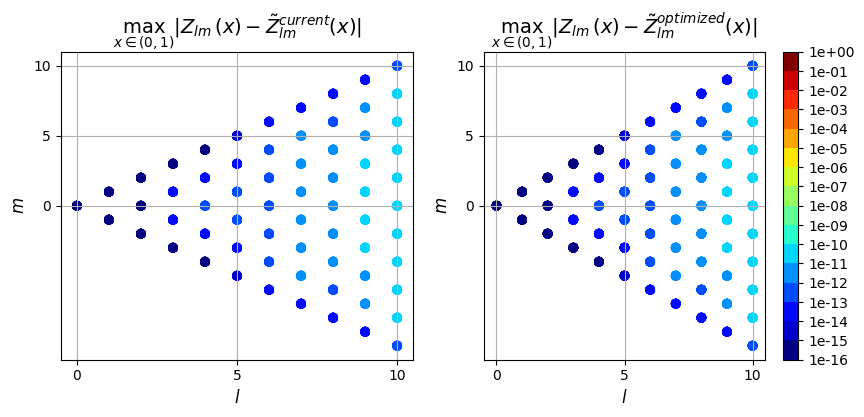

In [ ]:
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "Custom cmap", cmaplist, cmap.N
)

# define the bins and normalize
bounds = np.logspace(-16, 0, 17)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(1, 2, squeeze=True, figsize=(10, 4))
im = ax[0].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zr3 - zt3), axis=0),
    norm=norm,
    cmap=cmap,
)
im = ax[1].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(opt_3 - zt3), axis=0),
    norm=norm,
    cmap=cmap,
)
cbar = fig.colorbar(im, ticks=bounds)
cbar.ax.set_yticklabels(["{:.0e}".format(foo) for foo in bounds])
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_xticks(np.arange(0, 15, 5))
ax[0].set_yticks(np.arange(0, 15, 5))
ax[1].set_xticks(np.arange(0, 15, 5))
ax[1].set_yticks(np.arange(0, 15, 5))
ax[0].set_xlabel("$l$", fontsize=12)
ax[0].set_ylabel("$m$", fontsize=12)
ax[1].set_xlabel("$l$", fontsize=12)
ax[1].set_ylabel("$m$", fontsize=12)
ax[0].set_title(
    "$\max_{x \in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{current}(x)|$", fontsize=14
)
ax[1].set_title(
    "$\max_{x \in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{optimized}(x)|$", fontsize=14
);

In [ ]:
def zernike_radial_direct(r, n, m):
    """Radial part of zernike polynomials. Modified Prata's algorithm."""
    R = np.zeros((n, m))  # R_nmk

    M = 10  # dummy number for now
    for n in range(M):
        K_1 = 2 * n / (m + n)
        K_2 = 1 - K_1

        R[n, n] = r**n

        for m in range(n - 2, 1, -2):
            R[n, m] = r * K_1 * R[n - 1, m - 1] + K_2 * R[n - 2, m]

            if n % 2 == 0:
                R[n, 0] = 2 * r * R[n - 1, 1] - R[n - 2, 0]

            R_nm = np.sum([R * r**k for k in range(M)])

    # not sure if this part is needed
    R_k = np.zeros((n - m) / 2)
    for k in range((n - m) / 2):
        R_k[k] += (
            (-1) ** ((n - k) / 2)
            * factorial((n + k) / 2)
            / factorial((n - k) / 2)
            * factorial((k + abs(m)) / 2)
            * factorial((k - abs(m)) / 2)
        )

    return R_nm

In [1]:
import jax
import jax.numpy as jnp

def square(x):
    return x ** 2

@jax.jit
def square_jit(x):
    return x ** 2

@jax.jit
@jnp.vectorize
def square_jit_vectorize(x):
    return x ** 2

array = jnp.arange(500)
%timeit _ = square(array).block_until_ready()
%timeit _ = square_jit(array).block_until_ready()
%timeit _ = square_jit_vectorize(array).block_until_ready()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


41.6 µs ± 396 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.83 µs ± 6.75 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1.83 µs ± 7.24 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
